In [1]:
import pandas as pd

In [2]:
# Load files
files = [
    'data_50_40.csv',
    "data_20_15.csv",
]
dfs = {
    file:pd.read_csv(file)
    for file in files
}

Remove invalid rows and convert values

In [3]:
# Remove rows with -1 PRB allocation
for file, df in dfs.items():
    dfs[file] = df[df['prb_alloc'] != -1]

In [4]:
# Transform DRB.UEThpUL from array to numeric
for file, df in dfs.items():
    df['DRB.UEThpUl'] = df['DRB.UEThpUl'].apply(lambda x: float(x.strip('[]')))

Some prb_alloc values appear more than others, so we balance the dataset to make all values appear the same number of times.

In [5]:
# Defining function to balance dataset
def balance_dataset(df, target_column, n_samples_per_class=None, random_state=42):
    """
    Balance dataset so all classes have equal number of samples.
    
    Parameters:
    - df: DataFrame
    - target_column: Column containing class labels
    - n_samples_per_class: Number of samples per class (default: min count)
    - random_state: Random seed for reproducibility
    """
    # Get value counts
    value_counts = df[target_column].value_counts()
    
    # If n_samples_per_class not specified, use minimum count
    if n_samples_per_class is None:
        n_samples_per_class = value_counts.min()
    else:
        # Make sure n_samples_per_class is not larger than any class
        n_samples_per_class = min(n_samples_per_class, value_counts.min())
    
    balanced_dfs = []
    
    for category in df[target_column].unique():
        category_df = df[df[target_column] == category]
        
        # If we have fewer samples than needed
        if len(category_df) < n_samples_per_class:
            # Oversample with replacement
            category_df_balanced = category_df.sample(
                n=n_samples_per_class, 
                replace=True, 
                random_state=random_state
            )
        else:
            # Sample without replacement
            category_df_balanced = category_df.sample(
                n=n_samples_per_class, 
                replace=False, 
                random_state=random_state
            )
        
        balanced_dfs.append(category_df_balanced)
    
    # Combine and shuffle
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return balanced_df

In [6]:
# Balancing each dataset
n_rows = min(df["prb_alloc"].value_counts().min() for df in dfs.values())
for file, df in dfs.items():
    dfs[file] = balance_dataset(df, target_column='prb_alloc', n_samples_per_class=n_rows)

Based on where the UL throughput stops increasing as we allocate resources, we define the number of PRBs needed for each channel condition.

In [7]:
# Defining the target PRB ratio for each channel condition
# It would be better to define this based on some statistical analysis rather than hardcoding based on observation
target_prb_ratios = {
    'data_50_40.csv': 66,
    "data_20_15.csv": 46,
}

# Adding the target PRB ratio to each dataset as a column
for file, df in dfs.items():
    df['target_prb_ratio'] = target_prb_ratios[file]


Now we concatenate all datasets and remove all columns that will not impact the training

In [8]:
df = pd.concat(dfs.values(), ignore_index=True)
df = df.drop(columns=['ue_id', "timestamp", "target_thr"])

In [9]:
df.describe()

,prb_alloc,DRB.UEThpUl,target_prb_ratio
count,3600.00000,3600.000000,3600.000000
mean,50.50000,4089.229722,56.000000
std,28.87008,1771.282222,10.001389
min,1.00000,0.000000,46.000000
25%,25.75000,2670.250000,46.000000
50%,50.50000,5130.500000,56.000000
75%,75.25000,5496.000000,66.000000
max,100.00000,9116.000000,66.000000


Let's see how the PRB allocation impacts the UL throughput, with one color for each channel condition

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


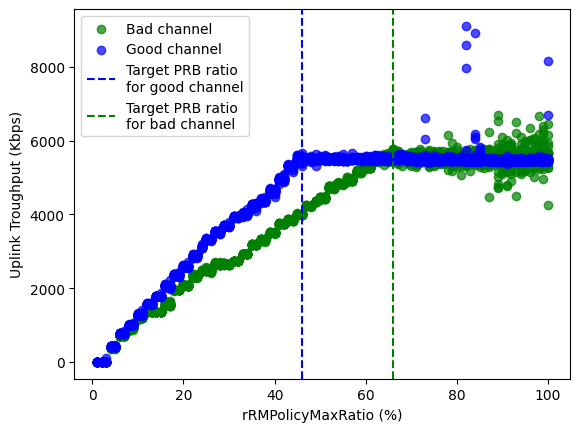

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
categories = df['target_prb_ratio'].unique()
colors = {
    46: 'blue',
    66: 'green',
}
caption = {
    46: 'Good channel',
    66: 'Bad channel',
}

for category in categories:
    subset = df[df['target_prb_ratio'] == category]
    ax.scatter(
        subset['prb_alloc'], subset['DRB.UEThpUl'],
        label=f'{caption[category]}', color=colors.get(category, 'black'), alpha=0.7
    )

for target, color in colors.items():
    ax.axvline(x=target, color=color, linestyle='--', label=f'Target PRB ratio\nfor {caption[target].lower()}')
ax.set_xlabel('rRMPolicyMaxRatio (%)')
ax.set_ylabel('Uplink Troughput (Kbps)')
ax.legend()
plt.savefig('prb_vs_thr.eps', format='eps', bbox_inches='tight')
plt.show()


Finally, we save the dataset for training the ML algorithm

In [11]:
df.to_csv('training_dataset.csv', index=False)